In [10]:
import warnings
import numpy as np
import sympy
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import requests
from PIL import Image, ImageDraw
from io import BytesIO
from lang_sam import LangSAM
import cv2

In [11]:
def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")


def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)


def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for i, mask_np in enumerate(masks):
        axes[i + 1].imshow(mask_np, cmap="gray")
        axes[i + 1].set_title(f"Mask {i+1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()


def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis("off")

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(
            logit.item(), 2
        )  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle(
            (x_min, y_min),
            box_width,
            box_height,
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(
            x_min,
            y_min,
            f"Confidence: {confidence_score}",
            fontsize=8,
            color="red",
            verticalalignment="top",
        )

    plt.show()


def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")


def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")


def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")


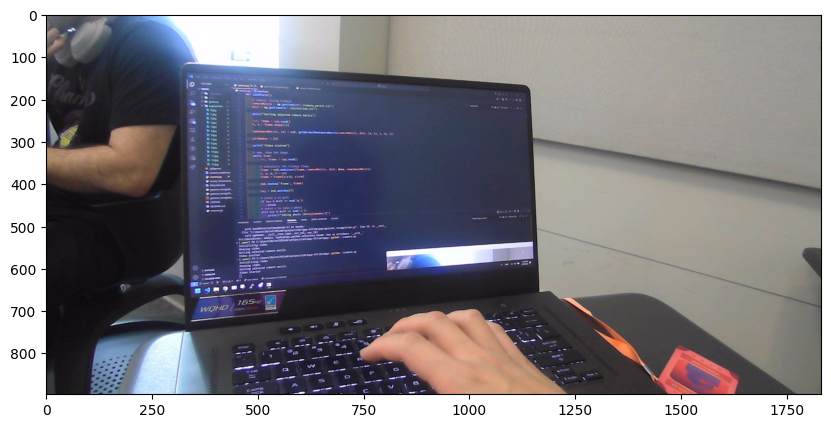

In [12]:
text_prompt = "screen"
image = 'images/2.jpg'

image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [13]:
model = LangSAM(sam_type='vit_b')
image_pil = Image.fromarray(image)
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\aaaab\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


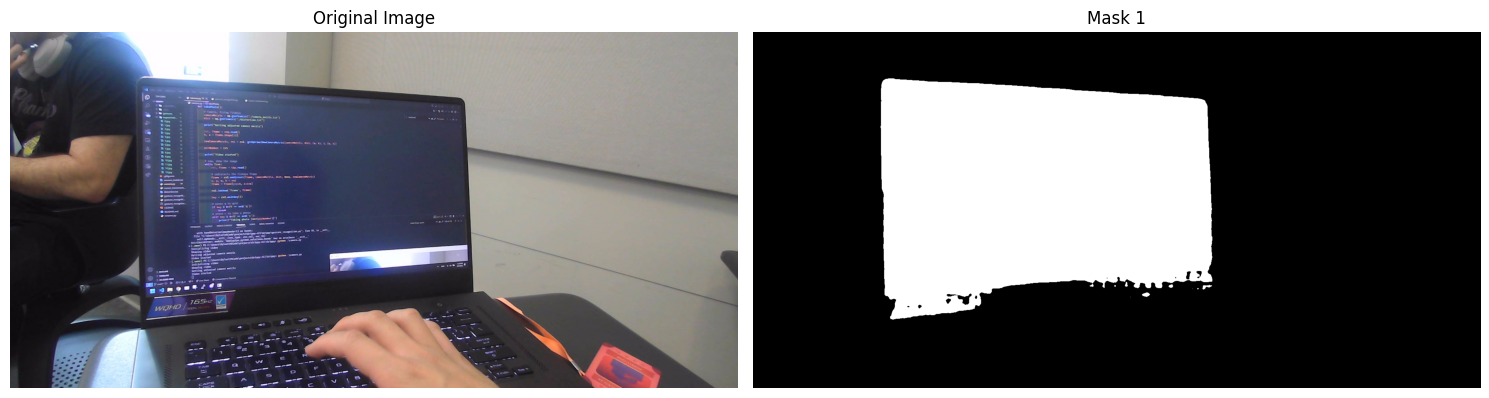

In [14]:
masks_np = [mask.squeeze().cpu().numpy() for mask in masks]
display_image_with_masks(image_pil, masks_np)

In [28]:
def draw_principal_axes(binary_mask):
    # Find all non-zero points (mask points)
    points = np.column_stack(np.where(binary_mask > 0))
    
    # Calculate the centroid of these points
    centroid = np.mean(points, axis=0)
    
    # Calculate the covariance matrix of the points
    cov_matrix = np.cov(points.T)
    
    # Compute the eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort the eigenvalues and eigenvectors by descending order of eigenvalues
    sort_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sort_indices]
    eigenvectors = eigenvectors[:, sort_indices]
    
    # Determine the angle for the principal axis
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    rotation_degree = np.degrees(angle)
    
    # Creating a visualization
    vis = cv2.cvtColor(binary_mask.astype(np.uint8)*255, cv2.COLOR_GRAY2BGR)
    
    # Calculate line lengths for visualization based on eigenvalues
    length_major = np.sqrt(eigenvalues[0]) * 4  # Scale factor for visualization
    length_minor = np.sqrt(eigenvalues[1]) * 4
    
    # Calculate points for major axis line
    line_major_start = (int(centroid[1] + length_major * np.cos(angle)), int(centroid[0] + length_major * np.sin(angle)))
    line_major_end = (int(centroid[1] - length_major * np.cos(angle)), int(centroid[0] - length_major * np.sin(angle)))
    
    # Calculate points for minor axis line
    line_minor_start = (int(centroid[1] + length_minor * np.cos(angle + np.pi/2)), int(centroid[0] + length_minor * np.sin(angle + np.pi/2)))
    line_minor_end = (int(centroid[1] - length_minor * np.cos(angle + np.pi/2)), int(centroid[0] - length_minor * np.sin(angle + np.pi/2)))
    
    # Draw the major and minor axis lines
    cv2.line(vis, line_major_start, line_major_end, (0, 255, 0), 2)  # Green for major axis
    cv2.line(vis, line_minor_start, line_minor_end, (255, 0, 0), 2)  # Blue for minor axis
    
    print(f"Rotation degree: {rotation_degree}")
    
    return rotation_degree, vis

Rotation degree: 91.7964511120811


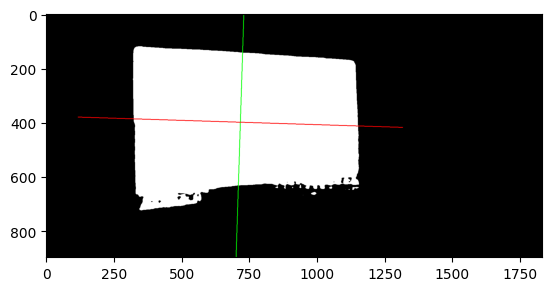

In [29]:
mask = masks_np[0]
rotation, result_image = draw_principal_axes(mask)
plt.imshow(result_image)

In [30]:
def find_minimum_area_rectangle(binary_mask, rotation_degree):
    """
    Find the minimum area rectangle for the given binary mask, using the specified rotation degree.

    Parameters:
    binary_mask (np.array): Binary image where the mask is represented with 255 and background with 0.
    rotation_degree (float): The rotation angle in degrees used to find the bounding box.

    Returns:
    np.array: Image with the minimum area rectangle drawn on it.
    """
    
    # Find contours of the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assume the largest contour is our target shape
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Calculate the rotated bounding rectangle of the largest contour
    rotated_rect = cv2.minAreaRect(largest_contour)
    
    # Set the rotation of the rectangle to the given degree
    rotated_rect = (rotated_rect[0], rotated_rect[1], rotation_degree)
    
    # Get the box points from the rotated rectangle
    box = cv2.boxPoints(rotated_rect)
    box = np.int0(box)
    
    # Draw the rectangle on a copy of the original image
    result_image = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(result_image, [box], 0, (0, 255, 0), 2)  # Green box
    
    return result_image

C:\Users\aaaab\AppData\Local\Temp\ipykernel_28832\563039749.py:27: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


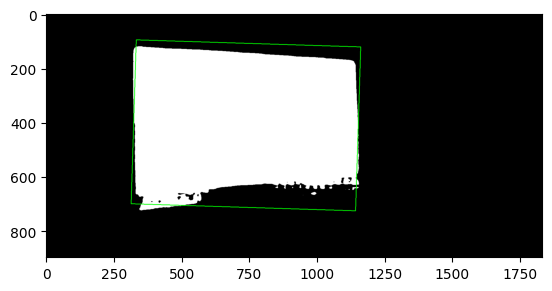

In [32]:
# Convert the mask to a binary image
result_image = find_minimum_area_rectangle(mask.astype(np.uint8)*255, rotation)
plt.imshow(result_image)